In [34]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from pandas.tools.plotting import scatter_matrix
from datetime import datetime
%matplotlib inline

In [2]:
os.chdir("C:\\Users\\xzou\\Downloads\\processedData")

In [151]:
def read_data(in_path, direction):
    data = pd.read_csv(in_path)
    if direction == "entry":
        data = data.drop([data.columns[0], data.columns[-1], data.columns[-3]], 1)
    else:
        data = data.drop([data.columns[0], data.columns[-1], data.columns[-4]], 1)
    return data

In [139]:
def select_by_date(data, date_low_bound, date_high_bound):
    """
    date_low_bound and date_high_bound are lists that tells
    the date, e.g. "2005-10-5" should be input as [2005, 10, 5]
    
    The input dataframe should have an attribute called time_window,
    whose value has the form "yyyy-mm-dd hh:mm:ss". And it should
    NOT have an attribute called "selection"
    """
    time_window = data["time_window"].tolist()
    ymd_time_window = [x.split(" ")[0] for x in time_window]
    ymd_list_time_window = [map(int, x.split("-")) for x in ymd_time_window]
    datetime_list = [datetime(x[0], x[1], x[2]) for x in ymd_list_time_window]
    low_datetime = datetime(date_low_bound[0], date_low_bound[1], date_low_bound[2])
    high_datetime = datetime(date_high_bound[0], date_high_bound[1], date_high_bound[2])
    remove_time_window = [True if x <= high_datetime and x >= low_datetime else False 
                          for x in datetime_list]
    data["selection"] = remove_time_window
    no_national_day_data = data.loc[data["selection"] == False]
    return no_national_day_data.drop("selection", 1)

In [140]:
def hist_visualizer(hidden_columns, data, figsize=(13,13), bins=40):
    data = data.drop(hidden_columns, 1)
    data.hist(figsize=figsize, bins=bins)

In [142]:
def scatter_matrix_visualizer(hidden_columns, data, figsize=(17,17)):
    data = data.drop(hidden_columns, 1)
    scatter_matrix(data, alpha=0.2, figsize=figsize, diagonal='kde')

In [150]:
def hour_mismatch(data, hours):
    volume = data["volume"].tolist()
    mismatch_volume = volume[hours * 3:]
    mismatch_volume.extend([-1] * (hours * 3))
    data["mismatch_volume"] = mismatch_volume
    data = data.drop("volume", 1)
    return data.loc[data["mismatch_volume"] != -1]

# EDA for Tollgate_1_entry

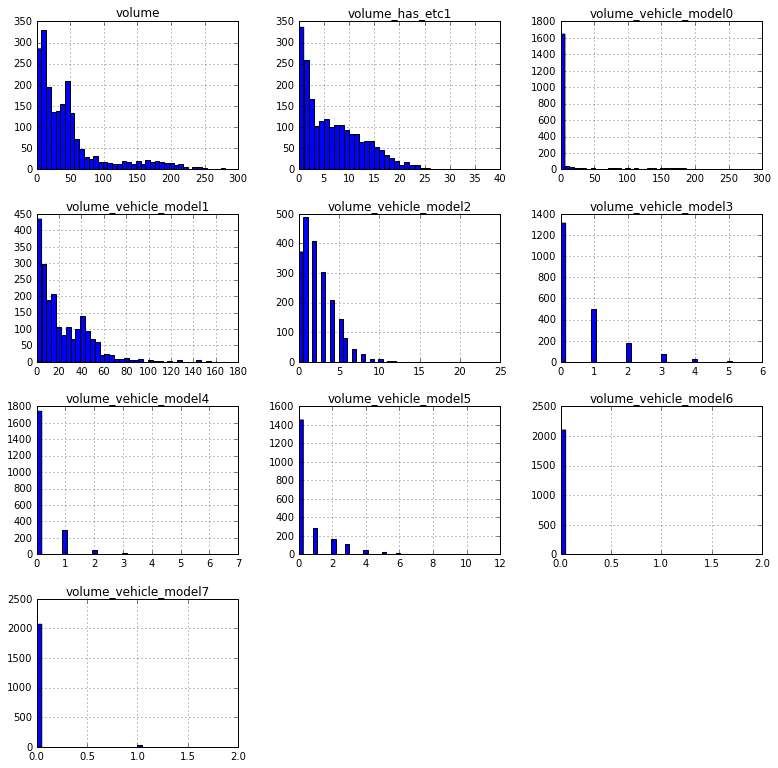

In [158]:
Tollgate1_entry = read_data("Tollgate1_entry.csv", "entry")
# Use the copy of the dataframe instead of that dataframe itself as an argument to prevent in-place modification
no_national_day_Tollgate1_entry = select_by_date(Tollgate1_entry.copy(deep=True), [2016,10,1], [2016,10,7])
hist_visualizer(["time_window"], Tollgate1_entry.copy(True))

Illustration:

The values of vehicle_model_6 for all records are 0. So it is fair to remove this attribute. 

The values of vehicle_model_7 are almost 0s for all records. So this attribute is also removed. 

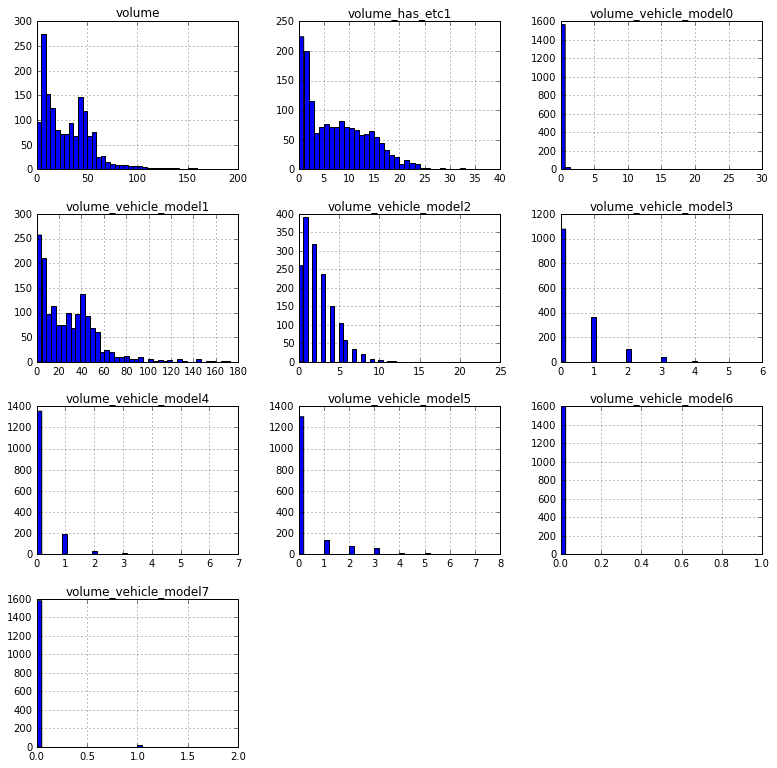

In [155]:
hist_visualizer(["time_window"], no_national_day_Tollgate1_entry.copy(True))

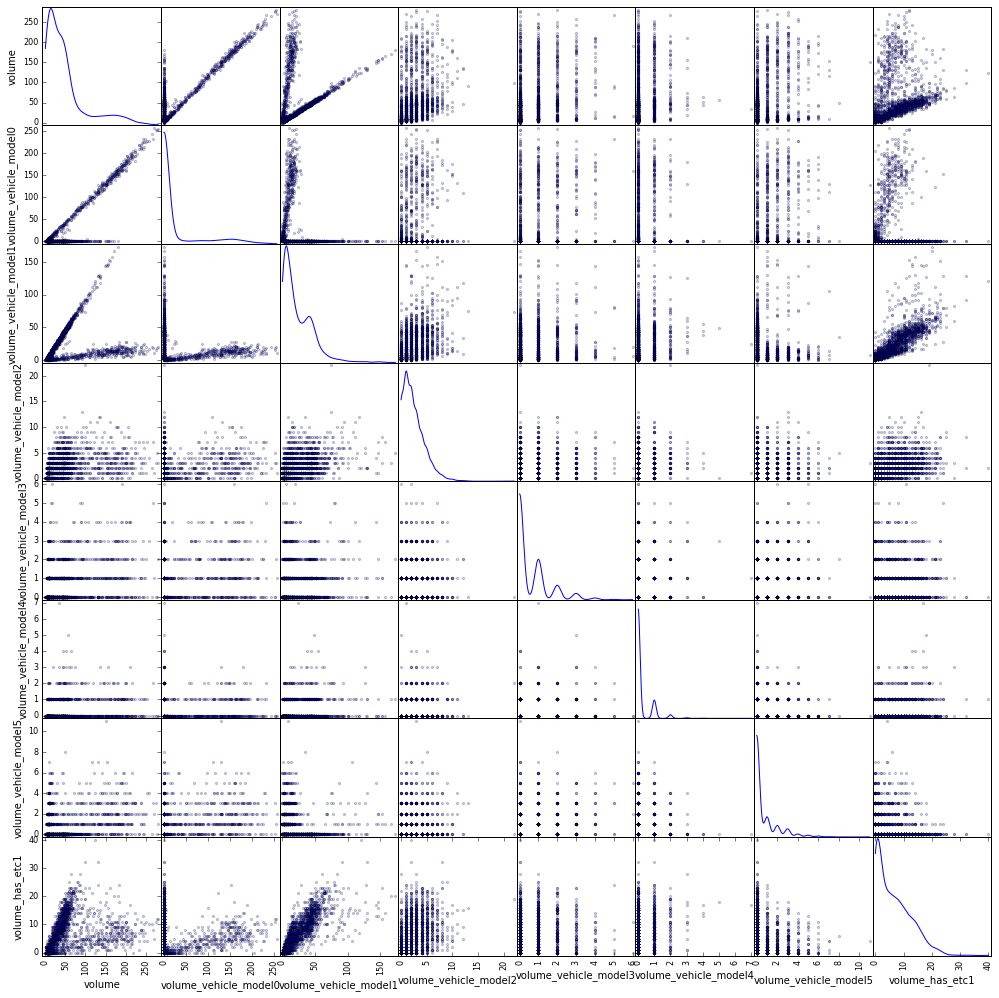

In [156]:
scatter_matrix_visualizer(["volume_vehicle_model6", 
                           "volume_vehicle_model7"],
                          Tollgate1_entry.copy(True))

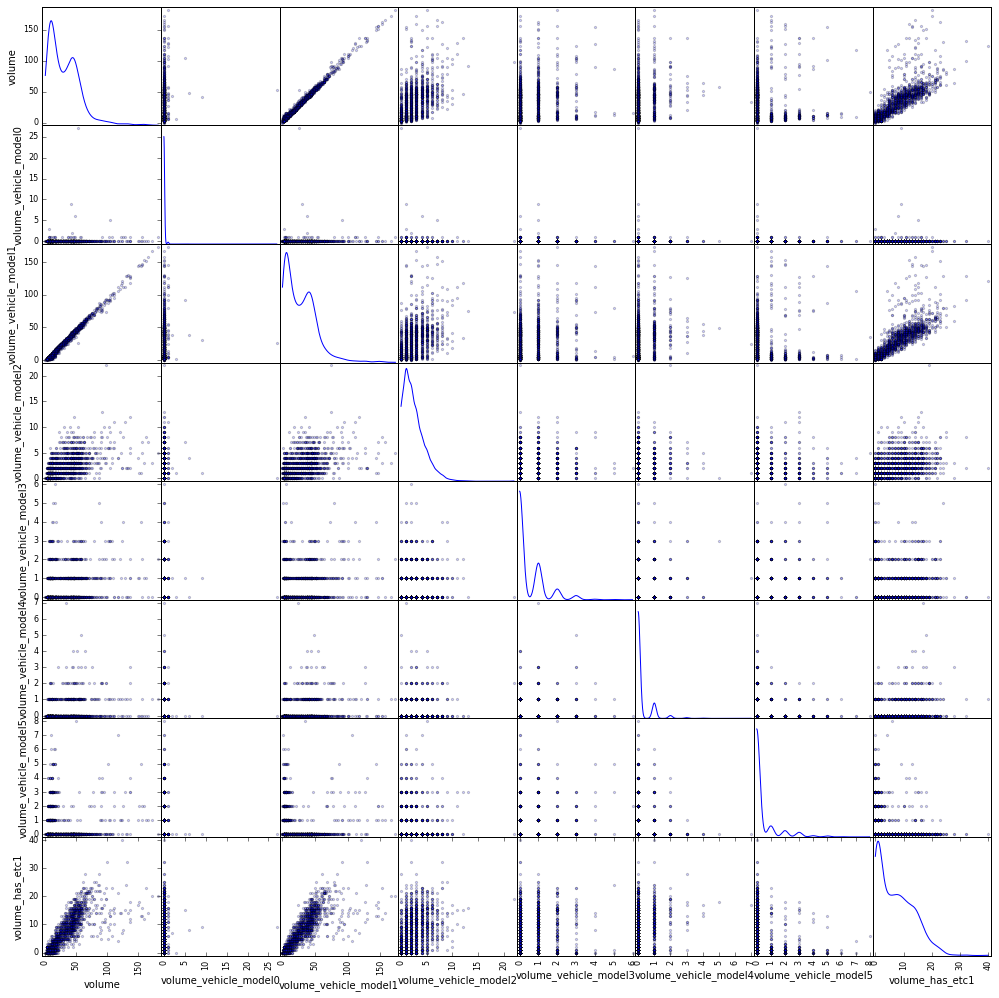

In [157]:
scatter_matrix_visualizer(["volume_vehicle_model6", 
                           "volume_vehicle_model7"],
                          no_national_day_Tollgate1_entry.copy(True))

# Scatterplot Matrix of mismatched data

In [85]:
mismatch_data = hour_mismatch(no_national_day_data.copy(True), 2)

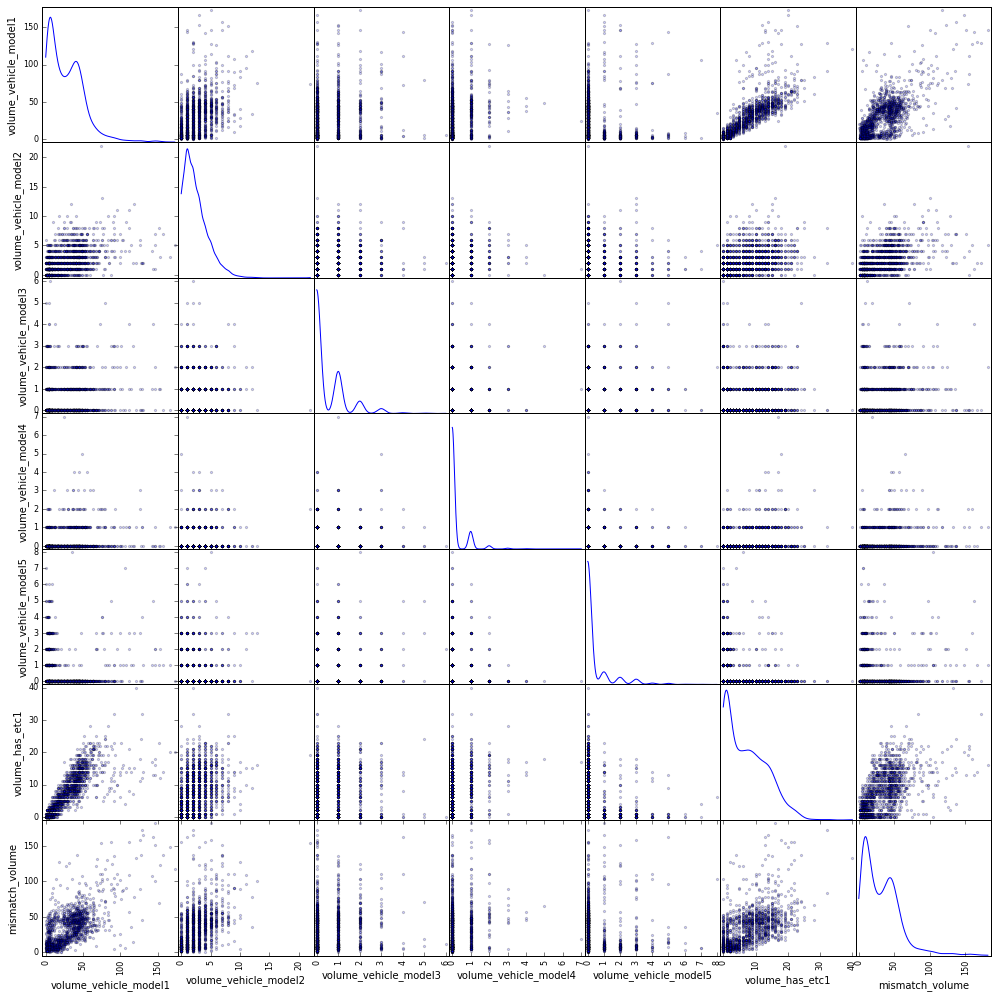

In [86]:
scatter_matrix_visualizer(["volume_vehicle_model0", 
#                          "volume_vehicle_model5", 
                           "volume_vehicle_model6", 
                           "volume_vehicle_model7", 
                           "volume_has_etc0"],
                          mismatch_data.copy(True))

Illustrations:
    
    1. has_etc is primarily influenced by vehicle_model_1, somehow influenced by vehicle_model_0 and sort of influenced by vehicle_model_5.
    
    2. there seems to be two sub-patterns in vehicle_model_0 ~ mismatch_volume and vehicle_model_1 ~ mismatch_volume.
    
    3. vehicle_model_3, vehicle_model_4 and vehicle_model_5 show strong discretized feature.

# make the tollage_1_entry test data

In [ ]:
def transform_time_window(row):
    time = row.split(" ")
    ymd = time[0]
    hms = time[1]
    m = int(hms.split(":")[1])
    if m >= 0 and m < 20:
        m = ":00"
    elif m >= 20 and m < 40:
        m = ":20"
    else:
        m = ":40"
    return ymd + " " + hms.split(":")[0] + m

In [101]:
table = "C:\\Users\\xzou\\Downloads\\dataSets\\testing_phase1\\volume_test1.csv"
data = pd.read_csv(table)

data_tollgate_1 = data.loc[data["tollgate_id"] == 1]
data_tollgate_1_entry = data_tollgate_1.loc[data_tollgate_1["direction"] == 0]
data_tollgate_1_entry = data_tollgate_1_entry.drop("vehicle_type", 1)

timedata = data_tollgate_1_entry["time"].tolist()
time_window = map(transform_time_window, timedata)
data_tollgate_1_entry["time_window"] = time_window

data_tollgate_1_entry = data_tollgate_1_entry.drop(["time", "tollgate_id", "direction"], 1)
expand_data = pd.get_dummies(data_tollgate_1_entry, columns = ["vehicle_model"])
# expand_data["volume"] = [1] * len(timedata)
expand_data = expand_data.drop("vehicle_model_0", 1)
data_grouped_by_timewindow = expand_data.groupby(["time_window"]).sum().reset_index()
data_grouped_by_timewindow = data_grouped_by_timewindow.drop("time_window", 1)
data_grouped_by_timewindow.to_csv("transformed_testdata_t10.csv", index=False)

In [102]:
data_grouped_by_timewindow

has_etc  vehicle_model_1  vehicle_model_2  vehicle_model_3  \
0         2             13.0              0.0              0.0   
1         5             13.0              4.0              0.0   
2         9             16.0              3.0              2.0   
3        13             22.0              7.0              0.0   
4         5             25.0              3.0              0.0   
5        10             41.0              5.0              1.0   
6        13             48.0              4.0              0.0   
7         7             36.0              2.0              0.0   
8        11             35.0              0.0              0.0   
9        12             55.0              2.0              0.0   
10       15             42.0              2.0              0.0   
11       16             46.0              7.0              0.0   
12        1             10.0              2.0              0.0   
13        4             13.0              3.0              0.0   
14        4             11.0              3.0              2.0   
15        9             15.0              5.0              1.0   
16       10             33.0              5.0              0.0   
17       15             38.0              3.0              0.0   
18        8             35.0              5.0              0.0   
19        9             31.0              3.0              0.0   
20       16             45.0              5.0              0.0   
21        5             38.0              1.0              0.0   
22       12             36.0              4.0              0.0   
23       11             36.0              0.0              0.0   
24        4              7.0              1.0              0.0   
25        3             15.0              1.0              0.0   
26        8             18.0              2.0              2.0   
27        4             16.0              5.0              0.0   
28        8             31.0              2.0              0.0   
29        7             34.0              3.0              0.0   
..      ...              ...              ...              ...   
54       11             35.0              1.0              1.0   
55       13             45.0              2.0              0.0   
56       17             51.0              1.0              0.0   
57        9             43.0              3.0              1.0   
58       23             51.0              1.0              3.0   
59       13             48.0              4.0              2.0   
60        3             10.0              3.0              0.0   
61        1              4.0              6.0              0.0   
62        3              4.0              2.0              2.0   
63        5             14.0              3.0              0.0   
64       10             18.0              5.0              1.0   
65        4             27.0              3.0              0.0   
66       20             57.0              4.0              0.0   
67       22             62.0              0.0              2.0   
68       18             57.0              2.0              1.0   
69       17             58.0              2.0              0.0   
70       15             55.0              3.0              0.0   
71       12             58.0              2.0              1.0   
72        4             12.0              6.0              0.0   
73        9             18.0              3.0              0.0   
74        7             21.0              1.0              2.0   
75        8             31.0              2.0              0.0   
76       11             28.0              6.0              0.0   
77       15             38.0              4.0              1.0   
78        3             46.0              3.0              1.0   
79       13             43.0              4.0              0.0   
80        7             25.0              1.0              0.0   
81        7             47.0              2.0              0.0   
82       15             44.0              4.

# EDA for Tollgate_1_exit

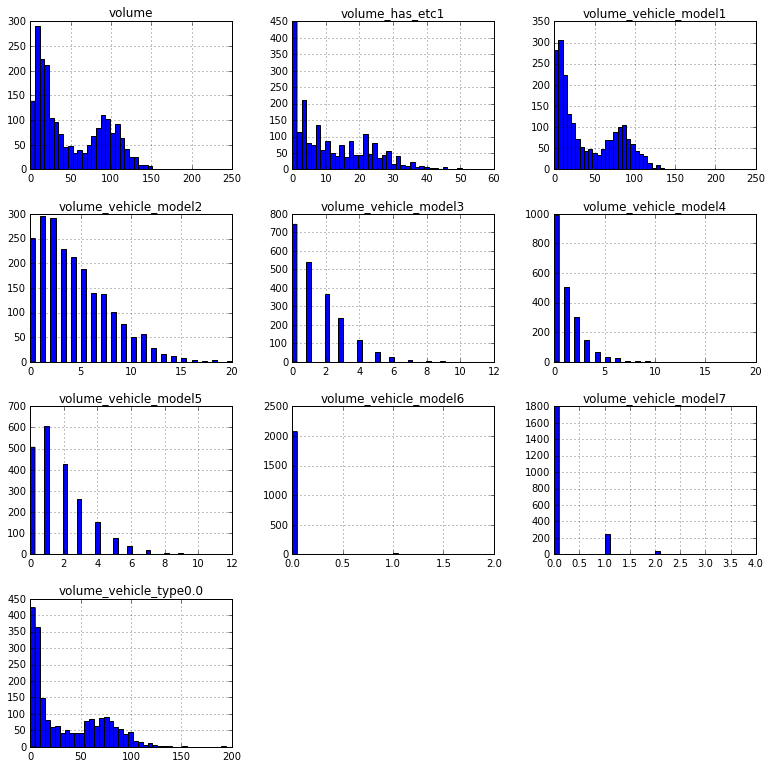

In [159]:
Tollgate1_exit = read_data("Tollgate1_exit.csv", "exit")
# Use the copy of the dataframe instead of that dataframe itself as an argument to prevent in-place modification
no_national_day_Tollgate1_exit = select_by_date(Tollgate1_exit.copy(deep=True), [2016,10,1], [2016,10,7])
hist_visualizer(["time_window"], Tollgate1_exit.copy(True))

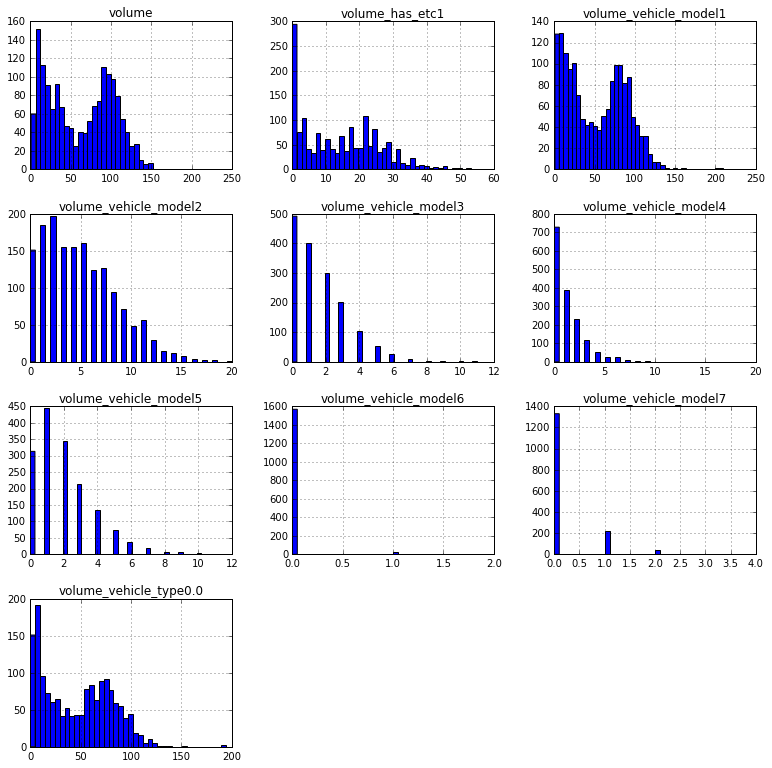

In [160]:
hist_visualizer(["time_window"], no_national_day_Tollgate1_exit.copy(True))

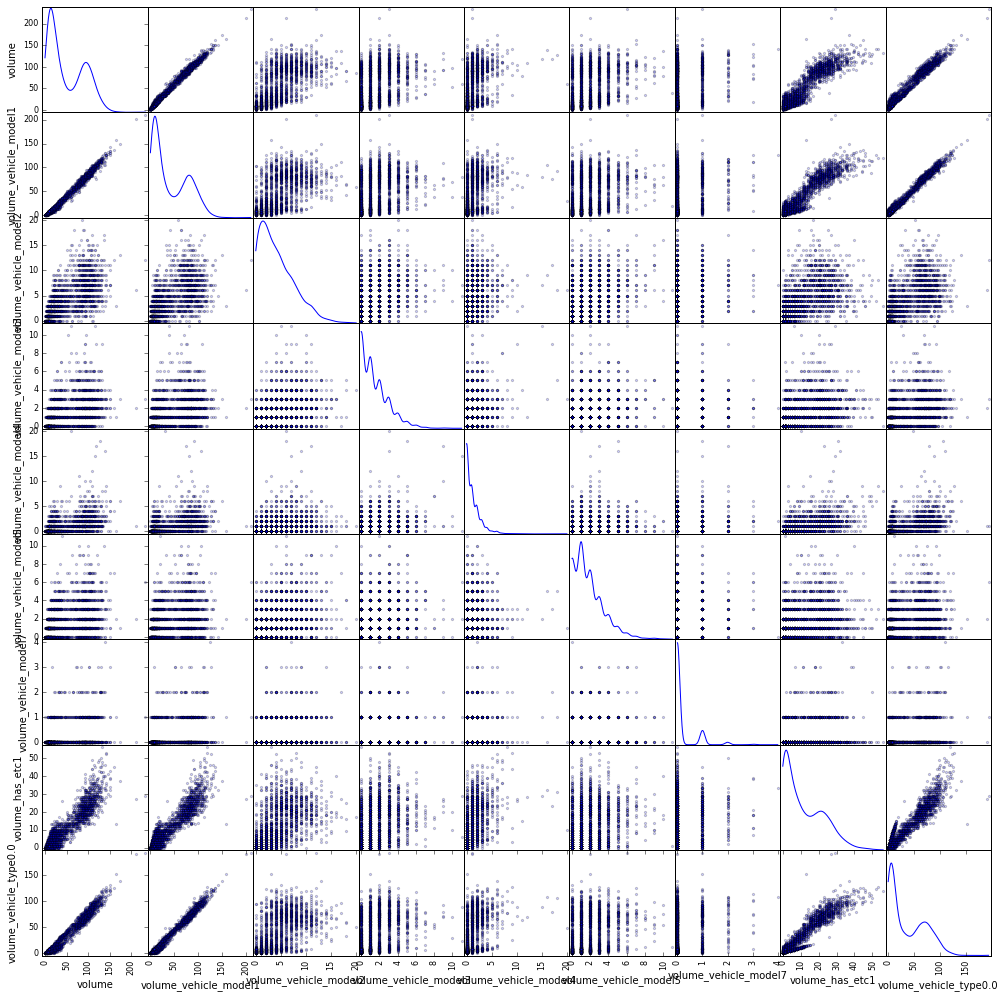

In [161]:
scatter_matrix_visualizer(["volume_vehicle_model6"], Tollgate1_exit.copy(True))

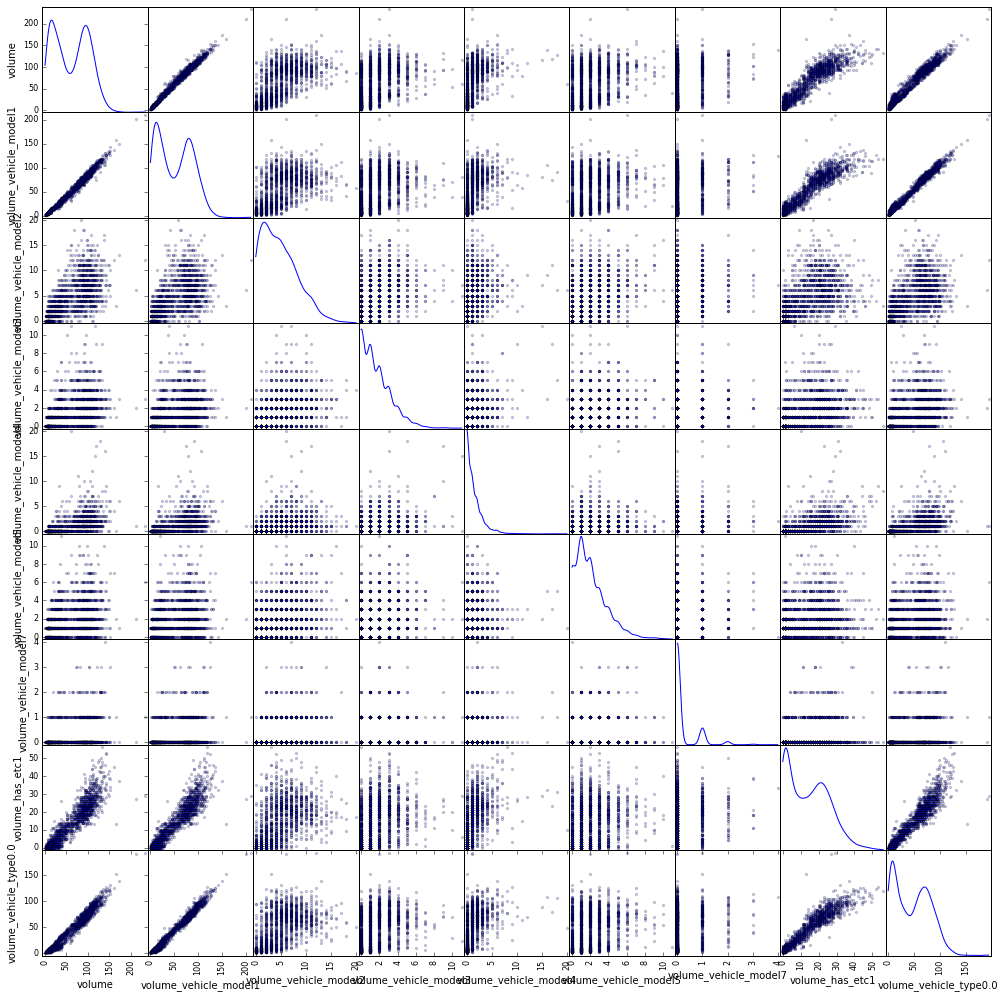

In [162]:
scatter_matrix_visualizer(["volume_vehicle_model6"], no_national_day_Tollgate1_exit.copy(True))

Illustration:

vehicle_model_1 are the type of vehicle that is mainly influenced by removing data during the national day

# EDA for Tollgate_2_entry

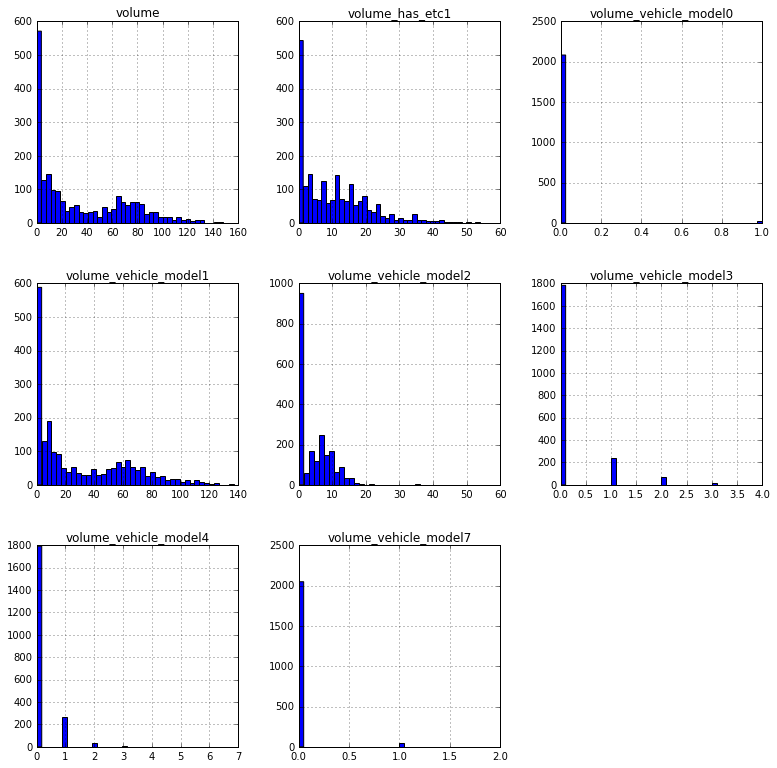

In [163]:
Tollgate2_entry = read_data("Tollgate2_entry.csv", "entry")
# Use the copy of the dataframe instead of that dataframe itself as an argument to prevent in-place modification
no_national_day_Tollgate2_entry = select_by_date(Tollgate2_entry.copy(deep=True), [2016,10,1], [2016,10,7])
hist_visualizer(["time_window"], Tollgate2_entry.copy(True))

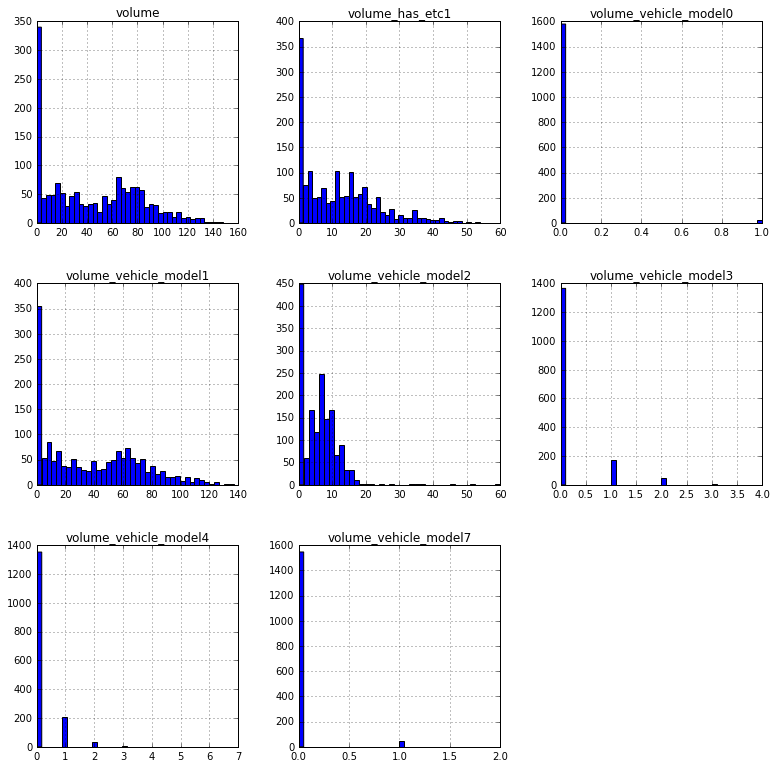

In [164]:
hist_visualizer(["time_window"], no_national_day_Tollgate2_entry.copy(True))

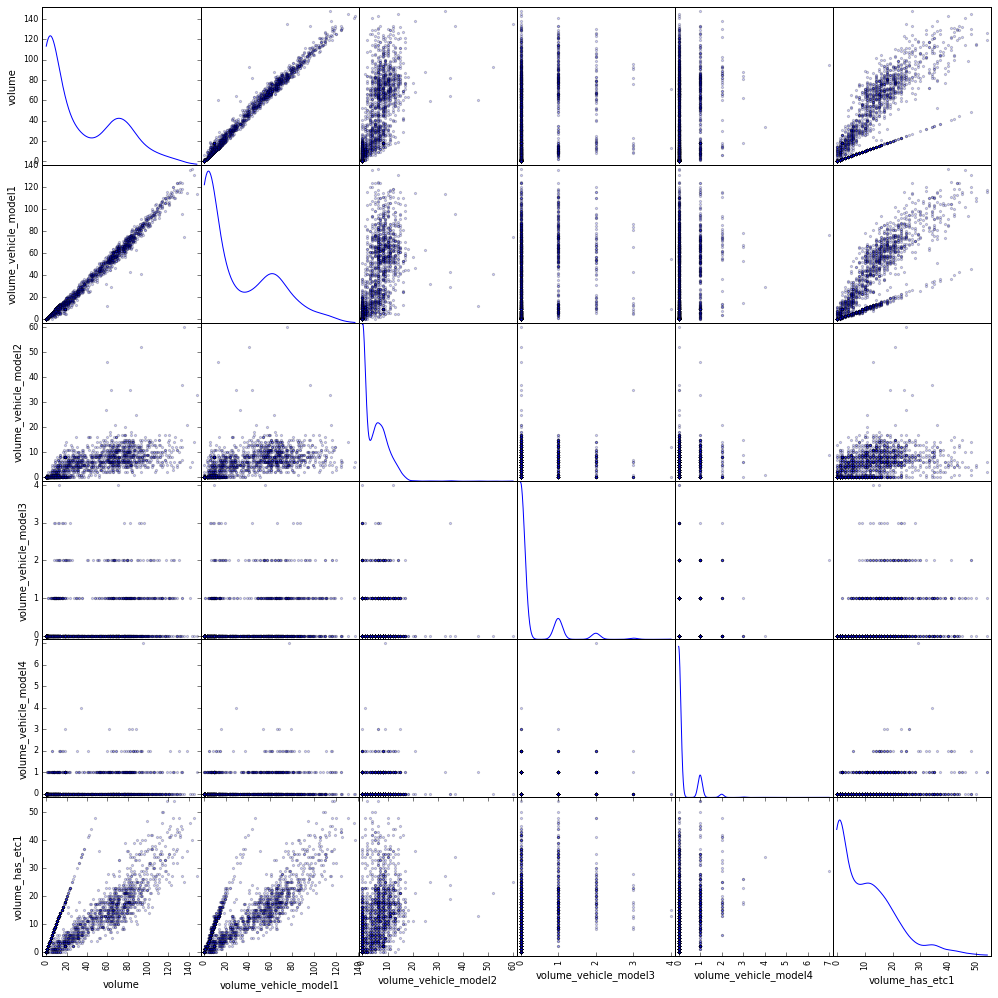

In [165]:
scatter_matrix_visualizer(["volume_vehicle_model0", "volume_vehicle_model7"], Tollgate2_entry.copy(True))

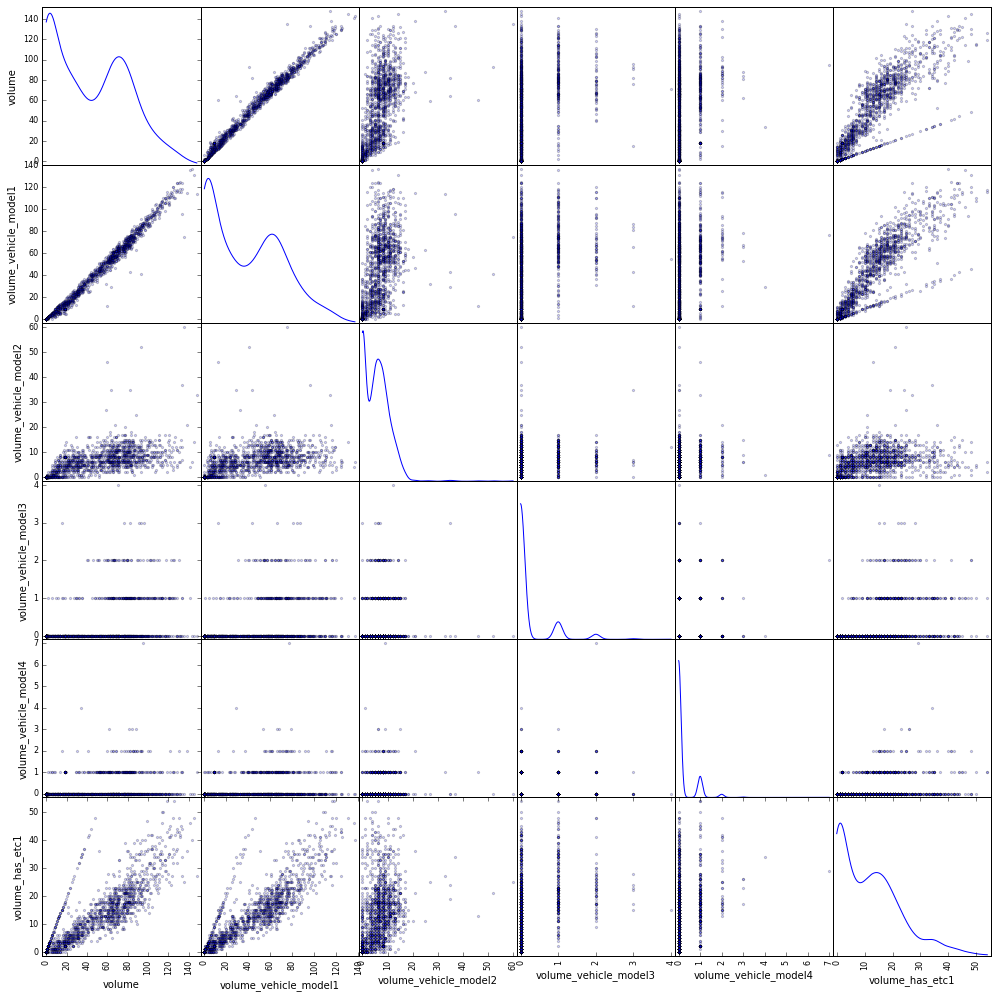

In [166]:
scatter_matrix_visualizer(["volume_vehicle_model0", "volume_vehicle_model7"], no_national_day_Tollgate2_entry.copy(True))

# EDA for Tollgate_3_entry

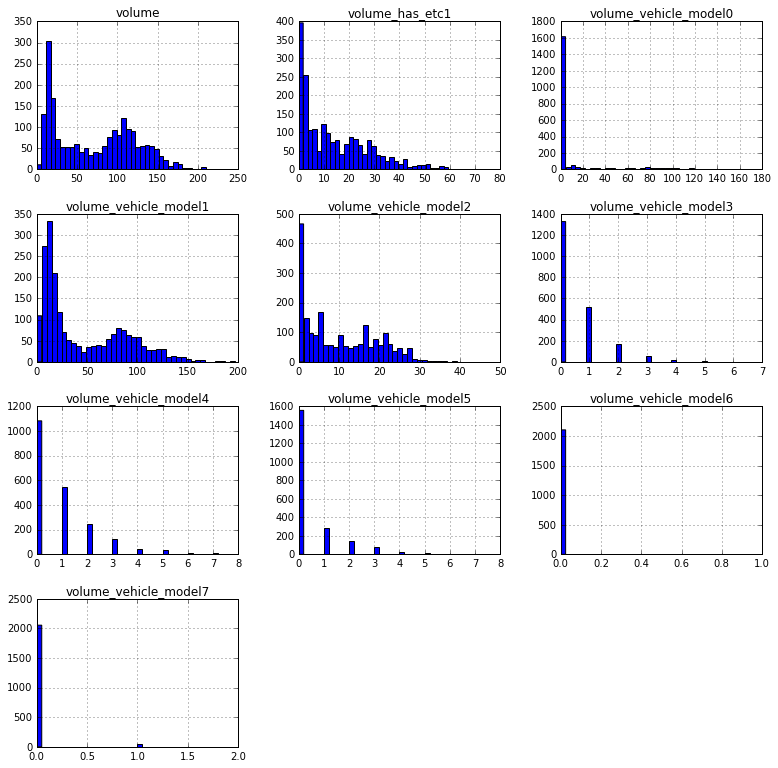

In [167]:
Tollgate3_entry = read_data("Tollgate3_entry.csv", "entry")
# Use the copy of the dataframe instead of that dataframe itself as an argument to prevent in-place modification
no_national_day_Tollgate3_entry = select_by_date(Tollgate3_entry.copy(deep=True), [2016,10,1], [2016,10,7])
hist_visualizer(["time_window"], Tollgate3_entry.copy(True))

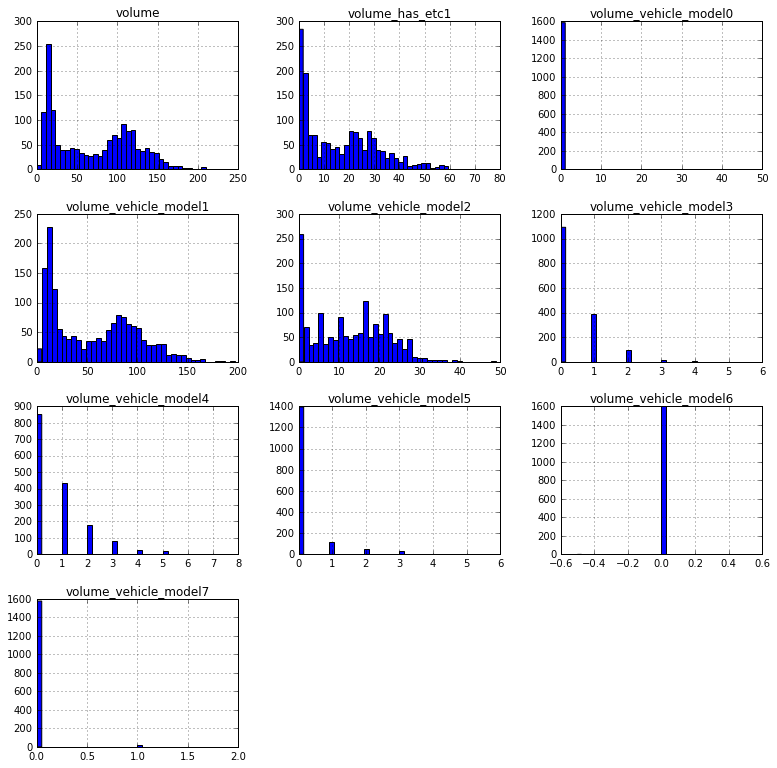

In [168]:
hist_visualizer(["time_window"], no_national_day_Tollgate3_entry.copy(True))

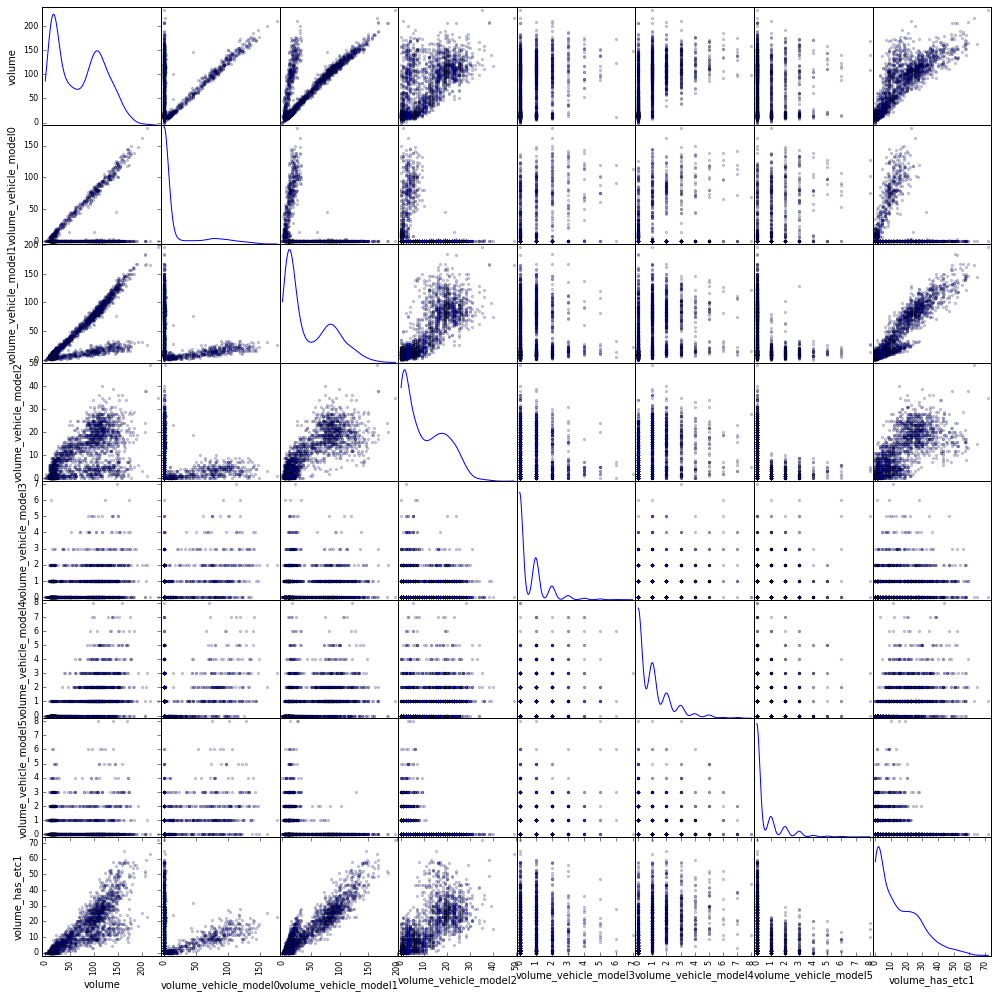

In [169]:
scatter_matrix_visualizer(["volume_vehicle_model6", "volume_vehicle_model7"], Tollgate3_entry.copy(True))

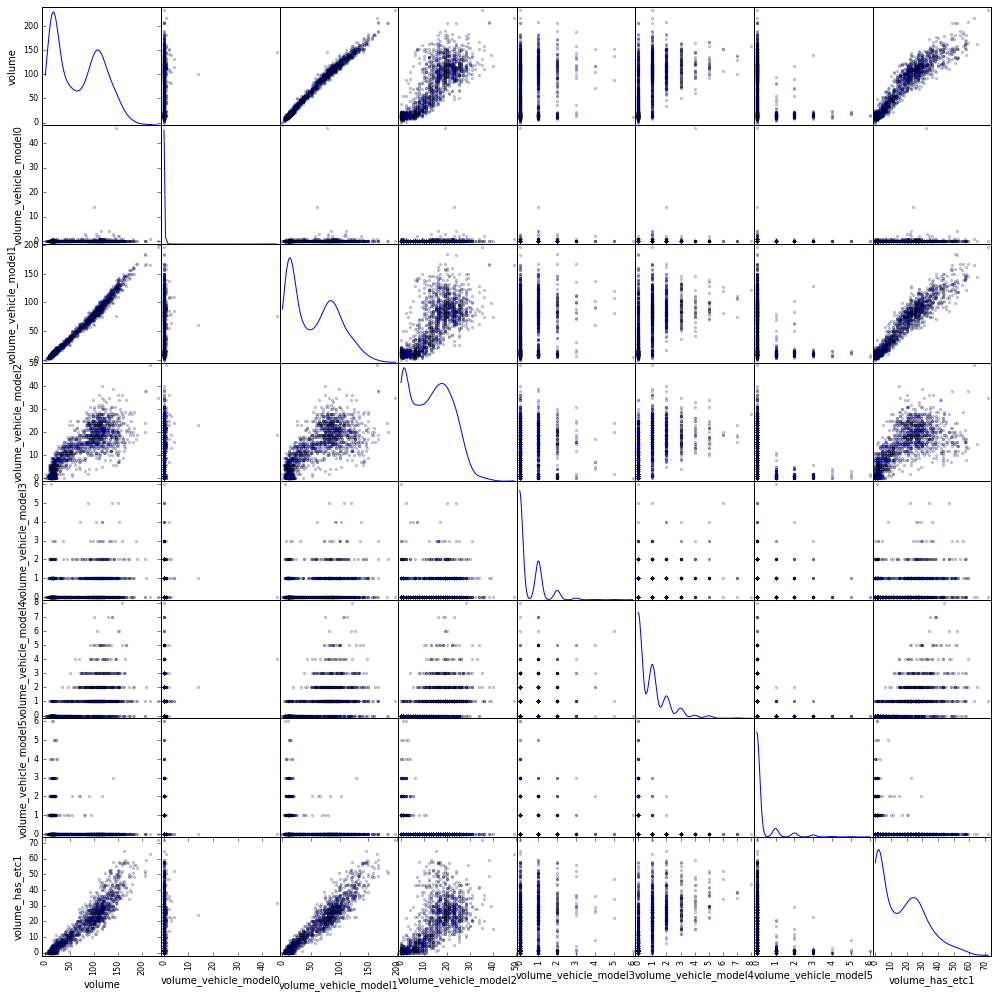

In [170]:
scatter_matrix_visualizer(["volume_vehicle_model6", "volume_vehicle_model7"], no_national_day_Tollgate3_entry.copy(True))

# EDA for Tollgate_3_exit

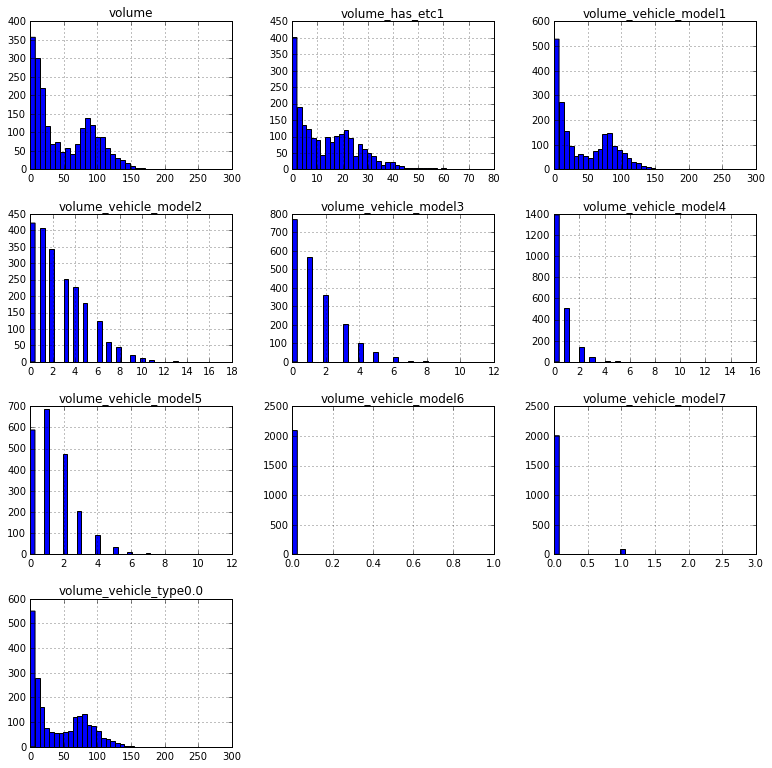

In [171]:
Tollgate3_exit = read_data("Tollgate3_exit.csv", "exit")
# Use the copy of the dataframe instead of that dataframe itself as an argument to prevent in-place modification
no_national_day_Tollgate3_exit = select_by_date(Tollgate3_exit.copy(deep=True), [2016,10,1], [2016,10,7])
hist_visualizer(["time_window"], Tollgate3_exit.copy(True))

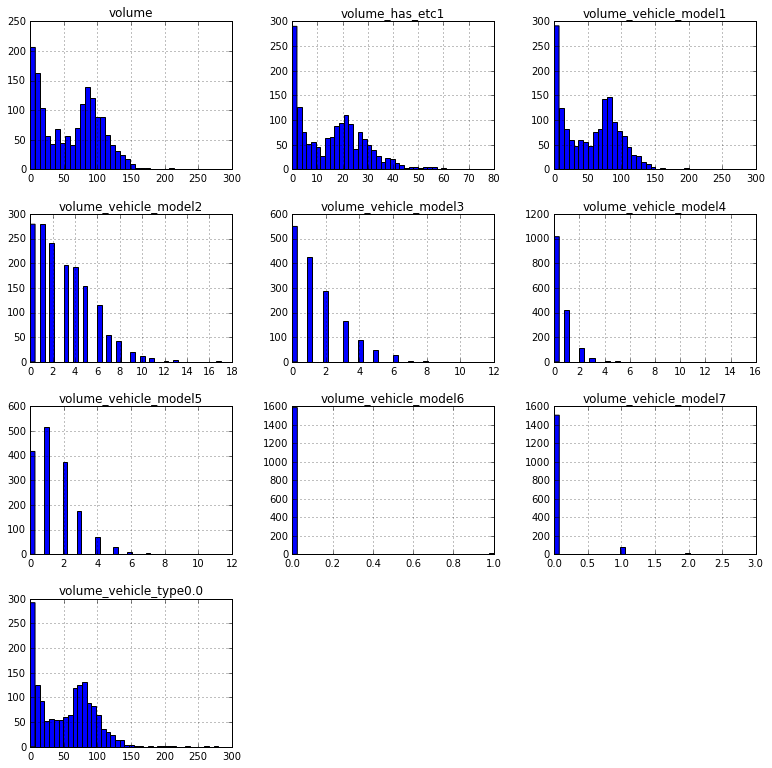

In [172]:
hist_visualizer(["time_window"], no_national_day_Tollgate3_exit.copy(True))

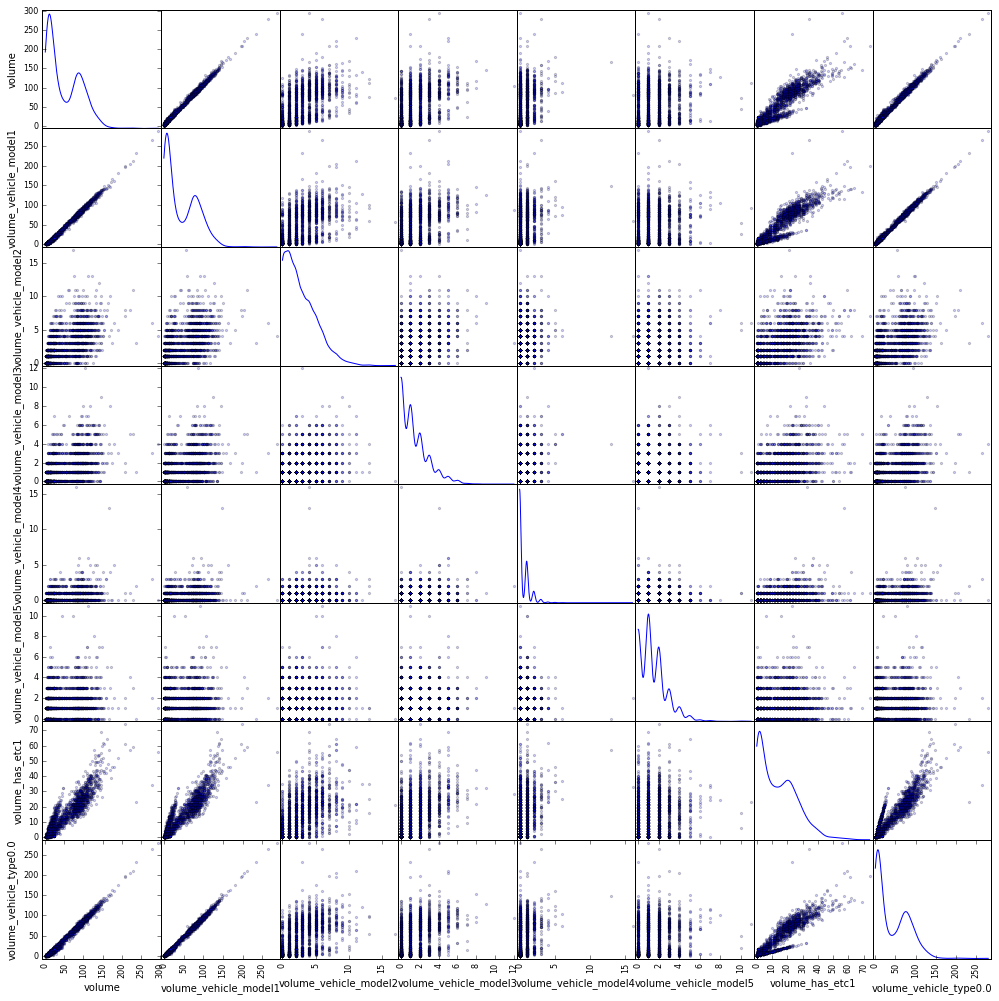

In [173]:
scatter_matrix_visualizer(["volume_vehicle_model6", "volume_vehicle_model7"], Tollgate3_exit.copy(True))

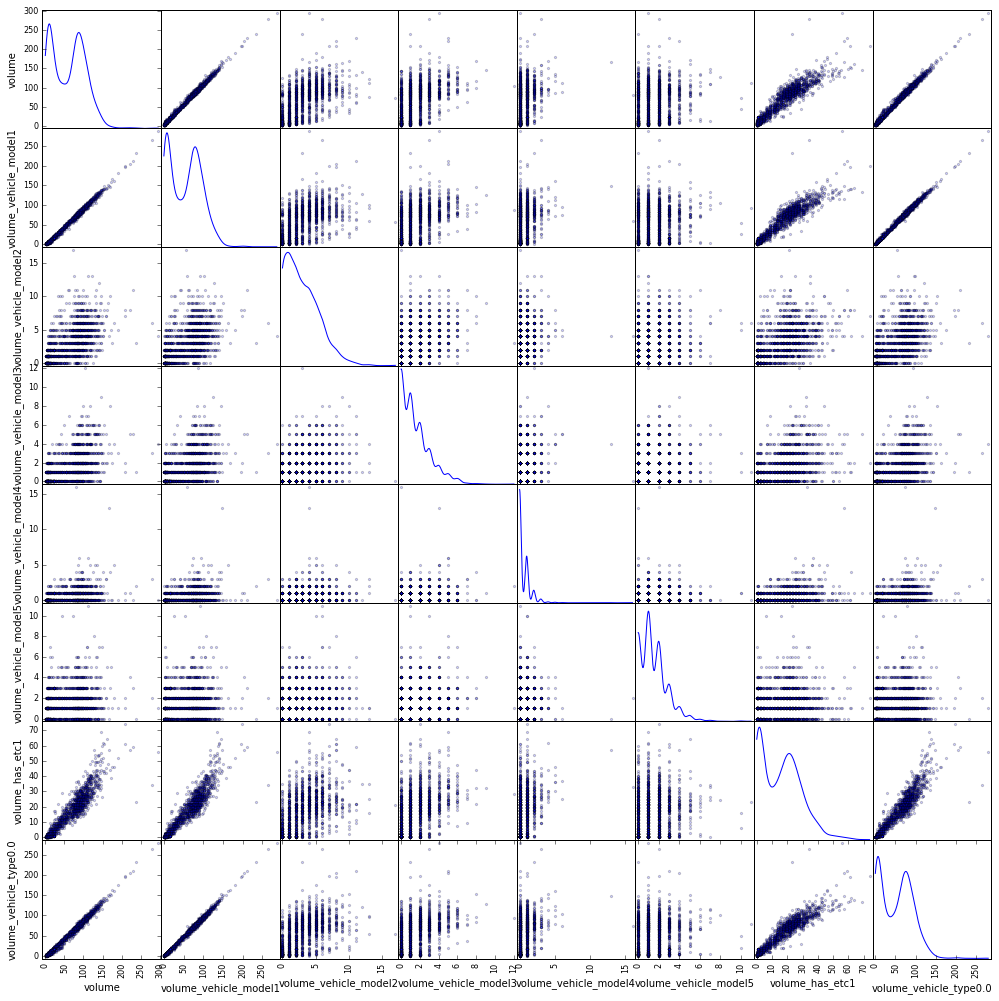

In [174]:
scatter_matrix_visualizer(["volume_vehicle_model6", "volume_vehicle_model7"], no_national_day_Tollgate3_exit.copy(True))